# Spotify EDA

The overall goal of this personal project is to use Spotify listening data to practice organizing and cleaning data, running some exploratory analyses, and implementing some basic machine learning models. 

This notebook primarily deals with exploratory data analysis, using dataframes that contain song metadata and audio feature data (see SpotifyEDA-get_features.ipynb). This is very much a work in progress; initial approach was to try and use audio feature data to fit a model that could predict play count, though these attempts weren't particularly successful and it seems likely that play count is not really an appropriate target feature. See below for attempts, + follow up thoughts on why this hasn't been successful thus far.

In [15]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# read in data
play_data = pd.read_pickle('filtered_song_data.pkl')
feature_data = pd.read_pickle('song_feature_data.pkl')
metadata = pd.read_pickle('unique_song_metadata.pkl')

# add play counts
feature_data = feature_data.set_index(['artist_track_name'])
feature_data['play_count'] = play_data['artist_track_name'].value_counts()[feature_data.index] #get play counts from data df, index with artist_track_name
feature_data.head()                                                        

,artist_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,play_count
artist_track_name,,,,,,,,,,,,,,,
TWICE__Breakthrough,"[k-pop, k-pop girl group]",0.868,0.728,6,-3.338,0,0.1100,0.04390,0.0,0.0975,0.616,112.006,217651,4,42
GOT7__너란 Girl Magnetic,"[k-pop, k-pop boy group]",0.720,0.870,0,-4.129,0,0.0445,0.05960,0.0,0.3460,0.842,109.960,203084,4,62
SE7EN__Better Together,[k-pop],0.782,0.813,8,-3.788,1,0.0385,0.00971,0.0,0.3440,0.788,119.998,218120,4,41
GOT7__Look,"[k-pop, k-pop boy group]",0.643,0.913,5,-1.724,0,0.1570,0.11300,0.0,0.3830,0.734,119.938,194535,4,61
TWICE__KNOCK KNOCK,"[k-pop, k-pop girl group]",0.673,0.968,1,-2.636,0,0.1310,0.02420,0.0,0.0587,0.476,129.972,195747,4,32


### Taking a closer look at the audio features provided by Spotify

In [41]:
feature_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,play_count
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1.470000e+03,1470.000000,1470.000000
mean,0.648550,0.635707,5.297279,-6.758352,0.604082,0.091666,0.268660,0.129202,0.174750,0.506280,118.155390,2.147710e+05,3.960544,10.398639
std,0.139971,0.218075,3.579030,3.648562,0.489213,0.089026,0.290925,0.285988,0.136102,0.229948,28.649118,1.017241e+05,0.301699,23.140651
min,0.152000,0.021200,0.000000,-28.174000,0.000000,0.023900,0.000056,0.000000,0.021500,0.033700,33.338000,4.078900e+04,1.000000,2.000000
25%,0.563250,0.484250,2.000000,-8.334750,0.000000,0.040500,0.034425,0.000000,0.091825,0.334250,97.347250,1.884330e+05,4.000000,2.000000
50%,0.667000,0.678000,5.000000,-6.047500,1.000000,0.057550,0.133000,0.000008,0.118000,0.510500,115.089000,2.096400e+05,4.000000,3.000000
75%,0.748000,0.814000,8.000000,-4.258000,1.000000,0.104000,0.451750,0.011900,0.220750,0.688000,130.779500,2.346352e+05,4.000000,6.000000
max,0.951000,0.988000,11.000000,-0.532000,1.000000,0.949000,0.990000,0.975000,0.930000,0.972000,219.142000,3.484983e+06,5.000000,455.000000


Can/should all of these features be used in model fitting?
- Mode & time_signature should be categorical.  
- Drop duration_ms; don't think it'll contribute
- Loudness and tempo are at different ranges from the rest; normalize

In [45]:
feat_copy = feature_data.copy()

#mode, & time_signature to categorical
feat_copy = pd.get_dummies(data=feat_copy, columns=['mode', 'time_signature'], prefix=['mode', 'time_sig'])

# normalize loudness & tempo
x = feat_copy[['loudness', 'tempo']]
loudness_tempo = (x - x.min())/(x.max()-x.min())
feat_copy[['loudness', 'tempo']] = loudness_tempo

# drop duration_ms
feat_copy.drop('duration_ms', axis=1, inplace=True)

### Check feature correlations

<AxesSubplot:>

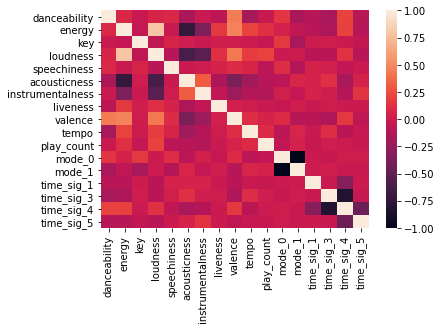

In [54]:
sns.heatmap(feat_copy.iloc[:,1:].corr()) #skip artist_genres

In [55]:
play_count_corr = feat_copy.iloc[:,1:].corr()['play_count'].sort_values(key=abs, ascending=False) #skip artist_genres
play_count_corr

play_count          1.000000
loudness            0.213302
energy              0.125360
instrumentalness   -0.123522
tempo               0.098450
acousticness       -0.090093
speechiness        -0.075226
valence             0.059118
mode_1              0.048346
mode_0             -0.048346
key                -0.030093
time_sig_5         -0.023403
time_sig_1         -0.022060
time_sig_3          0.020227
danceability       -0.012816
liveness           -0.011124
time_sig_4          0.001594
Name: play_count, dtype: float64

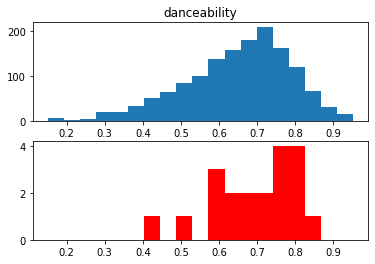

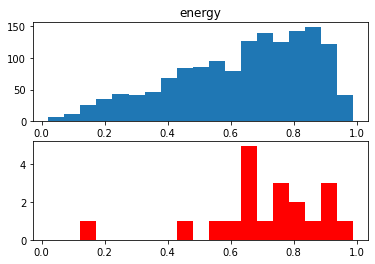

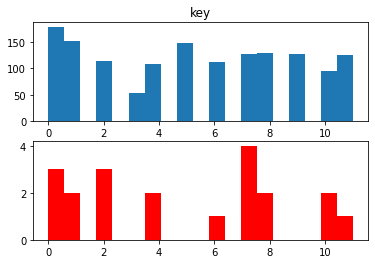

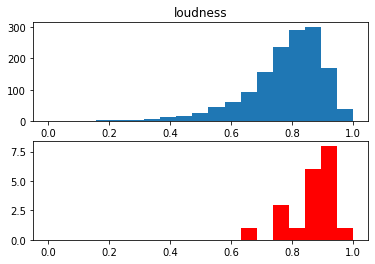

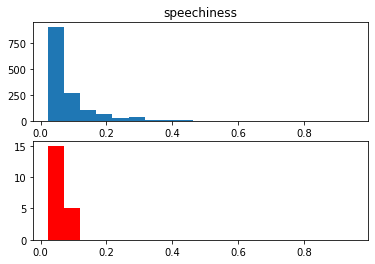

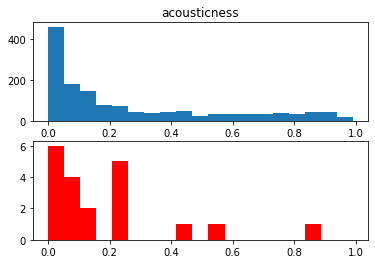

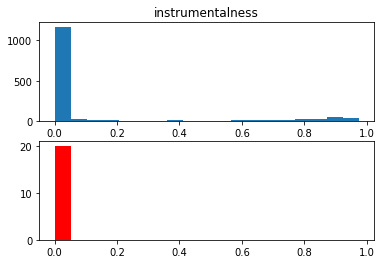

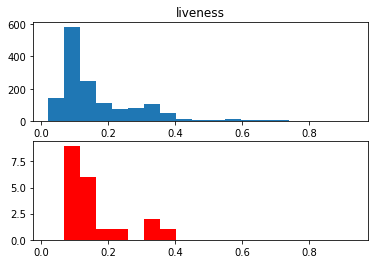

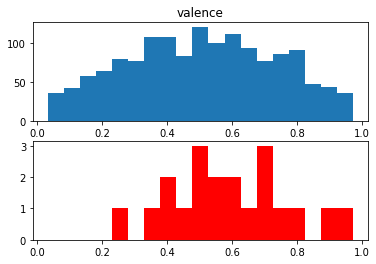

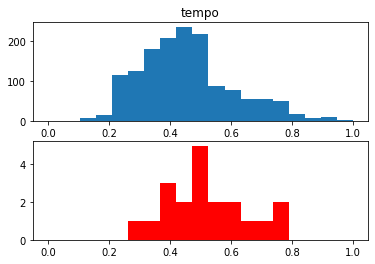

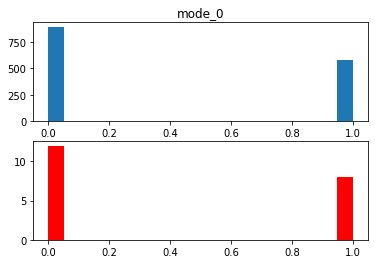

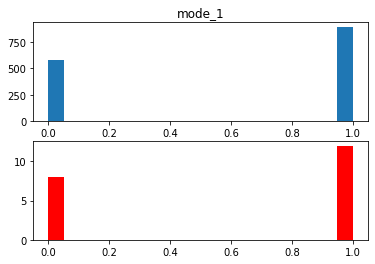

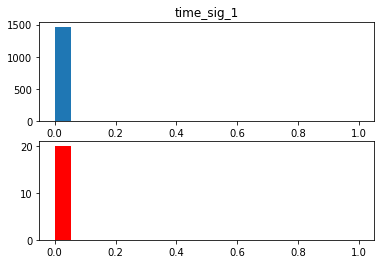

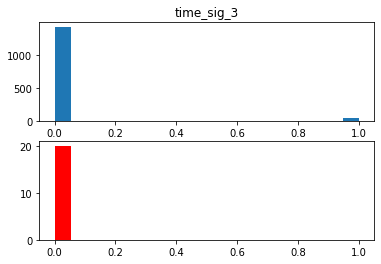

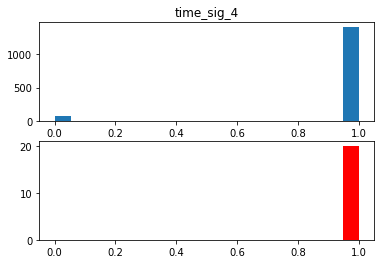

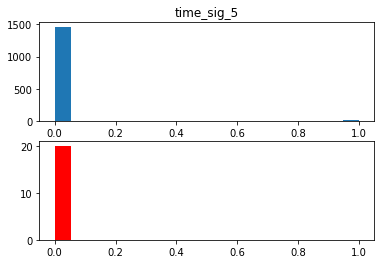

In [51]:
# how do features of top 20 most-played songs compare to the entire distribution?
top20 = play_data['artist_track_name'].value_counts()[0:20].index

def plot_histograms(df, feature):
    bin_edges = np.linspace(df[feature].min(), df[feature].max(), num=20)

    f = plt.figure()
    ax1 = f.add_subplot(2,1,1)
    plt.title(feature)
    ax1.hist(df[feature], bins=bin_edges)

    ax2 = f.add_subplot(2,1,2)
    ax2.hist(df.loc[top20,:][feature], bins=bin_edges, color='red')
    plt.show()

plot_cols = feat_copy.columns.drop(['artist_genres', 'play_count'])
for f in plot_cols:
    plot_histograms(feat_copy, f)

There doesn't seem to be any particular feature that would be good for predicting the most-played songs.. correlation values for play count are all fairly low, and among top 20 most-played songs, audio feature values tend to be pretty evenly spread throughout the distribution of all songs.

But, as a practice exercise, will still try to see if there's any way to predict play count using audio features. 

In [53]:
# import sklearn 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error

In [61]:
### k-nearest
df = feat_copy
features = feat_copy.columns.drop(['artist_genres', 'play_count'])
target = 'play_count'
num_folds = 10

kf = KFold(num_folds, shuffle=True)
rmse_compare = {}
print('Mean RMSE after {} folds, using ...'.format(num_folds))
for num_neighbors in range(5,11):
    knn_model = KNeighborsRegressor(n_neighbors=num_neighbors, algorithm='brute')
    mses = cross_val_score(knn_model, df[features], df[target], scoring='neg_mean_squared_error', cv=kf)
    rmses = np.sqrt(abs(mses))
    
    print('{} neighbors: {:.3f}'.format(num_neighbors, np.mean(rmses)))

Mean RMSE after 10 folds, using ...
5 neighbors: 23.333
6 neighbors: 22.717
7 neighbors: 23.482
8 neighbors: 22.641
9 neighbors: 22.660
10 neighbors: 21.950


In [62]:
### linear regression
def fit_lr_model(df, features, target, num_folds=10):
    kf = KFold(num_folds, shuffle=True)
    
    top_feat_per_fold = {}
    rmse_values = []
    fold_count = 0
    for train_idxs, test_idxs in kf.split(df[features]):
        train_features, test_features = df[features].iloc[train_idxs], df[features].iloc[test_idxs]
        train_target, test_target = df[target].iloc[train_idxs], df[target].iloc[test_idxs]

        lr_model = LinearRegression()
        lr_model.fit(train_features, train_target)

        coeffs = pd.Series(lr_model.coef_)
        coeffs_sorted = coeffs.sort_values(ascending=False)
        top_10_features = [features[i] for i in coeffs_sorted[0:10].index]
        top_feat_per_fold[fold_count] = top_10_features
        fold_count += 1

        predictions = lr_model.predict(test_features)

        mse = mean_squared_error(test_target, predictions)
        rmse = np.sqrt(abs(mse))
        rmse_values.append(rmse)
    
    return rmse_values, top_feat_per_fold

In [63]:
rmse_values, top_feat_per_fold = fit_lr_model(feat_copy, feat_copy.columns.drop(['artist_genres', 'play_count']), 'play_count') 

print('Mean RMSE: {:.3f}'.format(np.mean(rmse_values)))
print('Standard deviation: {:.3f}'.format(np.std(rmse_values)))
lowest_rmse_fold = np.argmin(rmse_values)
print('Lowest RMSE on fold {} ({:.3f}).\nTop 10 features: {}'.format(lowest_rmse_fold, 
                                                                     np.min(rmse_values),
                                                                     top_feat_per_fold[lowest_rmse_fold]))

Mean RMSE: 21.101
Standard deviation: 8.031
Lowest RMSE on fold 9 (12.890).
Top 10 features: ['loudness', 'tempo', 'time_sig_3', 'danceability', 'acousticness', 'mode_1', 'key', 'time_sig_4', 'instrumentalness', 'mode_0']


Resulting mean RMSE from model fitting is variable. Perhaps not surprising, given relatively low correlation scores between individual audio features and play count. 

Tried 2 other manipulations to see effect on RMSE: (1) adding a few artists as additional (categorical) features, and (2) focusing only on k-pop genre. Wondered if either would improve RMSE; for (1), chose artists that I listened to a lot, thinking that these should serve as good predictive features; for (2), wondered if focusing on k-pop genre would decrease variability of audio feature values and thus be easier to fit. Resulting comparisons are below - adding top artists generally improved RMSE, though not by much; filtering to only k-pop was actually worse - maybe not enough data samples in this case?

(FWIW, at one point I did try including *all* artists as categorical features (500+ features). This was bad - super high RMSEs unless some of the top artists happen to get weighed heavily (which I assume depends heavily on shuffling/KFold splitting of which songs happen to get seleted into train/test groups?).) 

[ ] instead of just top 10 features, figure out which, if any, were significant (e.g., statsmodels or regressors modules)


In [64]:
# get dummy categories for artist
df_artists = feat_copy.iloc[:,1:].copy() #drop artist_genres
df_artists['artist'] = df_artists.index.str.split('__').str[0]
df_artists['artist'] = pd.Categorical(df_artists['artist'])
dummies = pd.get_dummies(df_artists['artist'])
df_artists.drop(['artist'], axis=1, inplace=True)

# df with audio features + a few artists
df_artists = pd.concat([df_artists, dummies[['GOT7', 'DAY6', 'The Rose', 'Jus2', 'TWICE']]], axis=1)
df_artists.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,mode_1,time_sig_1,time_sig_3,time_sig_4,time_sig_5,GOT7,DAY6,The Rose,Jus2,TWICE
artist_track_name,,,,,,,,,,,,,,,,,,,,,
TWICE__Breakthrough,0.868,0.728,6,0.898488,0.1100,0.04390,0.0,0.0975,0.616,0.423392,...,0,0,0,1,0,0,0,0,0,1
GOT7__너란 Girl Magnetic,0.720,0.870,0,0.869872,0.0445,0.05960,0.0,0.3460,0.842,0.412381,...,0,0,0,1,0,1,0,0,0,0
SE7EN__Better Together,0.782,0.813,8,0.882208,0.0385,0.00971,0.0,0.3440,0.788,0.466405,...,1,0,0,1,0,0,0,0,0,0
GOT7__Look,0.643,0.913,5,0.956877,0.1570,0.11300,0.0,0.3830,0.734,0.466083,...,0,0,0,1,0,1,0,0,0,0
TWICE__KNOCK KNOCK,0.673,0.968,1,0.923884,0.1310,0.02420,0.0,0.0587,0.476,0.520086,...,0,0,0,1,0,0,0,0,0,1


In [65]:
# get subset of features df for kpop songs only
genre_lists = feat_copy['artist_genres'].reset_index(drop=True)
df_kpop = feat_copy[['k-pop' in genres for genres in genre_lists]]
df_kpop = df_kpop.drop('artist_genres', axis=1)
df_kpop.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,play_count,mode_0,mode_1,time_sig_1,time_sig_3,time_sig_4,time_sig_5
artist_track_name,,,,,,,,,,,,,,,,,
TWICE__Breakthrough,0.868,0.728,6,0.898488,0.1100,0.04390,0.0,0.0975,0.616,0.423392,42,1,0,0,0,1,0
GOT7__너란 Girl Magnetic,0.720,0.870,0,0.869872,0.0445,0.05960,0.0,0.3460,0.842,0.412381,62,1,0,0,0,1,0
SE7EN__Better Together,0.782,0.813,8,0.882208,0.0385,0.00971,0.0,0.3440,0.788,0.466405,41,0,1,0,0,1,0
GOT7__Look,0.643,0.913,5,0.956877,0.1570,0.11300,0.0,0.3830,0.734,0.466083,61,1,0,0,0,1,0
TWICE__KNOCK KNOCK,0.673,0.968,1,0.923884,0.1310,0.02420,0.0,0.0587,0.476,0.520086,32,1,0,0,0,1,0


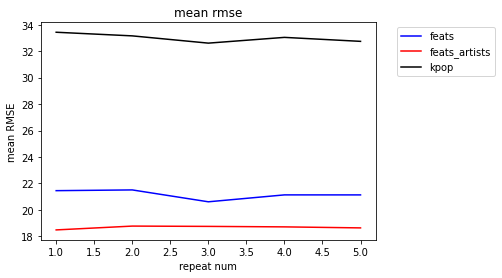

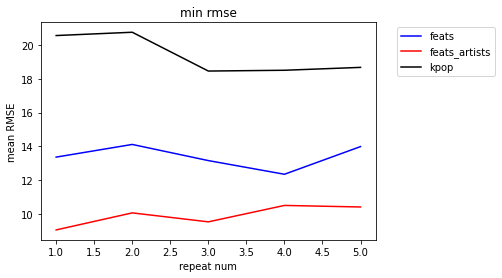

In [67]:
# fit linear model (with kfold) multiple times
# using normal audio features df, vs df with audio features + a few artists as add'l features, vs df with kpop only
num_repeats = 6 
x_range = range(1, num_repeats)

means = {}
mins = {}
for i in range(1,num_repeats):

    rmses_feat, _ = fit_lr_model(feat_copy, feat_copy.columns.drop(['artist_genres', 'play_count']), 'play_count')    
    rmses_artists, _ = fit_lr_model(df_artists, df_artists.columns.drop('play_count'), 'play_count')
    rmses_kpop, _ = fit_lr_model(df_kpop, df_kpop.columns.drop('play_count'), 'play_count')

    rmses = np.stack([rmses_feat, rmses_artists, rmses_kpop]) #each row has rmse values for one model

    means[i] = rmses.mean(axis=1) #mean for each model
    mins[i] = rmses.min(axis=1) #min for each model

means_df = pd.DataFrame.from_dict(means, orient='index', columns=['feats', 'feats_artists', 'kpop'])
mins_df = pd.DataFrame.from_dict(mins, orient='index', columns = ['feats', 'feats_artists', 'kpop'])

# plot mean RMSE for each round
plt.figure
colors = ['blue', 'red', 'black']
for ii in range(0,len(means_df.columns)):
    plt.plot(x_range, means_df.iloc[:,ii], color=colors[ii], label=means_df.columns[ii])
plt.title('mean rmse')
plt.xlabel('repeat num')
plt.ylabel('mean RMSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# plot lowest RMSE for each round
plt.figure
colors = ['blue', 'red', 'black']
for ii in range(0,len(mins_df.columns)):
    plt.plot(x_range, mins_df.iloc[:,ii], color=colors[ii], label=means_df.columns[ii])
plt.title('min rmse')
plt.xlabel('repeat num')
plt.ylabel('mean RMSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Changing target
As expected, adding a few known top artists helps a bit. But normally don't want to rely on these as features for the model.  
Narrowing by genre doesn't seem to help - in fact, RMSES are higher compared to when using full dataset.  

Aside from trying other models/parameters/feature combinations, another option is to change the target - perhaps predicting play count is too "unforgiving". Instead, try predicting probability that I'll like a song, rather than direct play count. This result would also generally be more useful in real application. 

But what metric to use to reflect this? 
- convert play counts to 'rating' - e.g., higher than middle of distribution of play counts is considered like vs not?
- predict whether song is in 'Liked' playlist (or any of my existing playlists)?

Hmmm not sure any of these are that workable, but let's try reframing as classification problem just for practice: fit model to return probability that play count will be higher than x.

In [294]:
play_counts = feat_copy['play_count']
play_counts.sort_values(ascending=False)

artist_track_name
The Rose__RED                            455
DAY6__Time of Our Life                   262
DAY6__Zombie                             223
GOT7__안 보여 Come On                       210
GOT7__You Calling My Name                198
                                        ... 
ITZY__24HRS                                2
ITZY__NOBODY LIKE YOU                      2
ITZY__THAT’S A NO NO                       2
Jengi__Bruh                                2
Autograf__Dream - Autograf’s Deep Dub      2
Name: play_count, Length: 1472, dtype: int64

In [295]:
play_counts.describe()

count    1472.000000
mean       10.389266
std        23.126377
min         2.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       455.000000
Name: play_count, dtype: float64

Wide range of play counts, but heavily skewed:

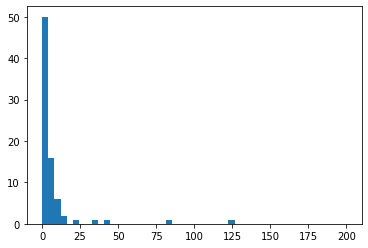

In [296]:
plt.hist(play_counts.value_counts(), bins=np.linspace(0,200,50))
plt.show()

In [309]:
print('{}% of songs were played more than play_count.mean()'.format(
    round((play_counts > play_counts.mean()).sum()/len(feat_copy)*100)))

18% of songs were played more than play_count.mean()


Will use mean of play_counts as threshold for classification, but will need to be mindful of class imbalance

In [320]:
df_prob = feat_copy.copy()
df_prob.drop('artist_genres', axis=1, inplace=True)
df_prob['play_count_cat'] = 0
df_prob.loc[df_prob['play_count'] > play_counts.mean(), 'play_count_cat'] = 1
df_prob

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_0,...,key_10,key_11,mode_0,mode_1,time_sig_1,time_sig_3,time_sig_4,time_sig_5,play_count,play_count_cat
artist_track_name,,,,,,,,,,,,,,,,,,,,,
TWICE__Breakthrough,0.868,0.728,0.898488,0.1100,0.04390,0.000000,0.0975,0.616,0.423392,0,...,0,0,1,0,0,0,1,0,42,1
GOT7__너란 Girl Magnetic,0.720,0.870,0.869872,0.0445,0.05960,0.000000,0.3460,0.842,0.412381,1,...,0,0,1,0,0,0,1,0,62,1
SE7EN__Better Together,0.782,0.813,0.882208,0.0385,0.00971,0.000000,0.3440,0.788,0.466405,0,...,0,0,0,1,0,0,1,0,41,1
GOT7__Look,0.643,0.913,0.956877,0.1570,0.11300,0.000000,0.3830,0.734,0.466083,0,...,0,0,1,0,0,0,1,0,61,1
TWICE__KNOCK KNOCK,0.673,0.968,0.923884,0.1310,0.02420,0.000000,0.0587,0.476,0.520086,0,...,0,0,1,0,0,0,1,0,32,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N.Flying__GOOD BAM,0.741,0.898,0.959229,0.0672,0.27900,0.000000,0.1560,0.800,0.401945,0,...,0,0,0,1,0,0,1,0,2,0
Eric Nam__Hold Me,0.535,0.564,0.751538,0.0422,0.46100,0.000000,0.1060,0.234,0.279402,0,...,0,0,0,1,0,0,1,0,2,0
IU__Ending Scene,0.388,0.323,0.760292,0.0348,0.85100,0.000002,0.1430,0.232,0.460415,0,...,0,0,0,1,0,0,1,0,2,0


In [339]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [448]:
df = df_prob
features = df_prob.columns.drop(['play_count', 'play_count_cat'])
target = 'play_count_cat'
num_folds = 10

roc_scores = []
top_feat_per_fold = {}
fold_count = 0
predictions = []

kf = KFold(num_folds, shuffle=True)
for train_idxs, test_idxs in kf.split(df[features]):
    train_features, test_features = df[features].iloc[train_idxs], df[features].iloc[test_idxs]
    train_target, test_target = df[target].iloc[train_idxs], df[target].iloc[test_idxs]

    log_model = LogisticRegression(class_weight='balanced')
    log_model.fit(train_features, train_target)

    coeffs = log_model.coef_[0]
    coeffs_idxs_sorted = np.argsort(coeffs)[::-1] #idx of features, sorted from highest to lowest (pos to neg, not abs value)
    top_10_features = features[coeffs_idxs_sorted[0:10]]
    top_feat_per_fold[fold_count] = top_10_features
    fold_count += 1

#     predict_prob = log_model.predict_proba(test_features)
    predict_labels = log_model.predict(test_features)
    
    roc_scores.append(roc_auc_score(test_target, predict_labels))
    predictions.append(predict_labels)
